In [1]:
from fastai.text.all import *

In [2]:
humnumpth = untar_data(URLs.HUMAN_NUMBERS)

In [3]:
hntrain = open(humnumpth / 'train.txt').readlines()

In [4]:
hnvalid = open(humnumpth / 'valid.txt').readlines()

In [5]:
hnvalid[:5]

['eight thousand one \n',
 'eight thousand two \n',
 'eight thousand three \n',
 'eight thousand four \n',
 'eight thousand five \n']

In [6]:
hntrain[-5:]

['seven thousand nine hundred ninety five \n',
 'seven thousand nine hundred ninety six \n',
 'seven thousand nine hundred ninety seven \n',
 'seven thousand nine hundred ninety eight \n',
 'seven thousand nine hundred ninety nine \n']

In [7]:
human10k = [s.strip() for s in ["zero \n", *hntrain, "eight thousand \n", *hnvalid, "ten thousand \n"]]

In [8]:
obscene = f"{23 * 3}"

In [9]:
nonobscene_indices = [i for i in range(10001) if not re.search(obscene, f"{i}")]
obscene_indices = [i for i in range(10001) if re.search(obscene, f"{i}")]

In [10]:
nonobscene_numbers = [human10k[i] for i in nonobscene_indices]
obscene_numbers = [human10k[i] for i in obscene_indices]

In [11]:
nndf = pd.DataFrame(data={"txt": [s.strip() for s in nonobscene_numbers]})
ondf = pd.DataFrame(data={"txt": [s.strip() for s in obscene_numbers]})

In [12]:
nndf

,txt
0,zero
1,one
2,two
3,three
4,four
...,...
9697,nine thousand nine hundred ninety six
9698,nine thousand nine hundred ninety seven
9699,nine thousand nine hundred ninety eight
9700,nine thousand nine hundred ninety nine


In [13]:
ondf

,txt
0,sixty nine
1,one hundred sixty nine
2,two hundred sixty nine
3,three hundred sixty nine
4,four hundred sixty nine
...,...
294,nine thousand six hundred ninety eight
295,nine thousand six hundred ninety nine
296,nine thousand seven hundred sixty nine
297,nine thousand eight hundred sixty nine


In [14]:
ndb = DataBlock(blocks=TextBlock.from_df('txt',is_lm=True,seq_len=6),get_x=ColReader('text'),splitter=RandomSplitter(0.1))

In [15]:
bs=64

In [16]:
nndl = ndb.dataloaders(nndf, bs=bs)

In [17]:
nndl.vocab

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'thousand',
 'hundred',
 'one',
 'two',
 'three',
 'four',
 'five',
 'seven',
 'eight',
 'nine',
 'six',
 'twenty',
 'thirty',
 'forty',
 'fifty',
 'seventy',
 'eighty',
 'sixty',
 'ninety',
 'ten',
 'eleven',
 'twelve',
 'thirteen',
 'fourteen',
 'fifteen',
 'sixteen',
 'seventeen',
 'eighteen',
 'nineteen',
 'xxfake',
 'xxfake']

In [18]:
ondl = DataBlock(blocks=TextBlock.from_df('txt',is_lm=True,seq_len=6,vocab=nndl.vocab),get_x=ColReader('text'),splitter=RandomSplitter(0.1)).dataloaders(ondf, bs=bs)

In [19]:
nndl.show_batch()

,text,text_
0,xxbos eight hundred eighty seven xxbos,eight hundred eighty seven xxbos one
1,xxbos seven thousand ninety nine xxbos,seven thousand ninety nine xxbos six
2,forty seven xxbos eight thousand five,seven xxbos eight thousand five hundred
3,thousand four hundred eleven xxbos five,four hundred eleven xxbos five thousand
4,six thousand three hundred four xxbos,thousand three hundred four xxbos three
5,eight hundred seventy four xxbos five,hundred seventy four xxbos five hundred
6,eight xxbos two thousand three hundred,xxbos two thousand three hundred thirty
7,xxbos one thousand six hundred sixty,one thousand six hundred sixty one
8,hundred seventy six xxbos two hundred,seventy six xxbos two hundred forty


In [20]:
ondl.show_batch()

,text,text_
0,xxbos three thousand four hundred sixty,three thousand four hundred sixty nine
1,thousand sixty nine xxbos two thousand,sixty nine xxbos two thousand sixty
2,thousand eight hundred sixty nine xxbos,eight hundred sixty nine xxbos eight
3,thousand six hundred ninety eight xxbos,six hundred ninety eight xxbos seven
4,hundred ninety three xxbos six thousand,ninety three xxbos six thousand six
5,hundred ninety nine xxbos three thousand,ninety nine xxbos three thousand six
6,hundred sixty nine xxbos five thousand,sixty nine xxbos five thousand six
7,hundred seventy six xxbos five thousand,seventy six xxbos five thousand seven
8,hundred sixty nine xxbos six thousand,sixty nine xxbos six thousand nine


In [21]:
dataloader_to_lm_learner = lambda dl: language_model_learner(dl, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

In [22]:
lml = dataloader_to_lm_learner(nndl)

In [23]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.02754228748381138)

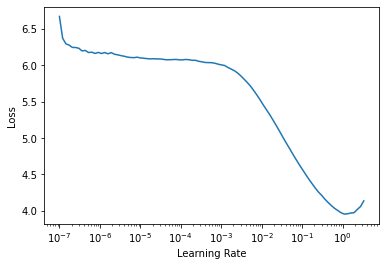

In [24]:
lml.lr_find()

In [25]:
lml.load('nnonlml')

In [26]:
lml.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.512263,1.631409,0.462630,5.111073,00:24
1,1.729823,1.517340,0.468750,4.560077,00:20
2,1.612885,1.494922,0.475749,4.458991,00:20
3,1.570883,1.486035,0.473698,4.419537,00:20
4,1.557382,1.478697,0.468913,4.387227,00:20
5,1.533888,1.475755,0.474609,4.374337,00:21
6,1.528814,1.473010,0.469564,4.362345,00:21
7,1.528247,1.469909,0.474967,4.348840,00:21
8,1.523659,1.467473,0.474512,4.338260,00:21
9,1.519779,1.467744,0.468522,4.339434,00:23


In [27]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=6.309573450380412e-07)

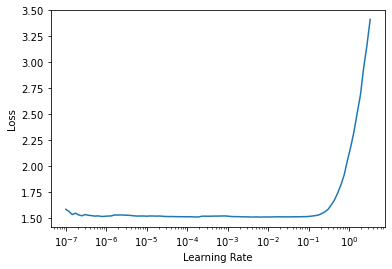

In [28]:
lml.lr_find()

In [29]:
lml.load('nnonlml')

In [30]:
np.unique([lml.predict("sixty", 1, temperature=5, no_bar=True) for i in range(20)], return_counts=True)

(array(['sixty', 'sixty eight', 'sixty four', 'sixty fourteen',
        'sixty hundred', 'sixty nineteen', 'sixty seventy', 'sixty six',
        'sixty sixteen', 'sixty thirty', 'sixty thousand', 'sixty three',
        'sixty twenty', 'sixty two', 'sixty xxeos'], dtype='<U14'),
 array([2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1]))

In [31]:
after_sixty = lambda lm,t,c: np.unique([lm.predict("sixty", 1, temperature=t, no_bar=True) for i in range(c)], return_counts=True)

In [32]:
sixteenth_to_two_temperatures_after_sixty = lambda lm: {i: after_sixty(lml,2**i,857) for i in np.arange(-4,3,2.)}

In [33]:
lml.save('nnon-10p'); sixteenth_to_two_temperatures_after_sixty(lml)

{-4.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty three', 'sixty two'], dtype='<U11'),
  array([ 61,   9,  14, 280,  14, 473,   6])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty nine',
         'sixty one', 'sixty seven', 'sixty six', 'sixty thousand',
         'sixty three', 'sixty two'], dtype='<U14'),
  array([ 10, 115,  62,  75,   5, 176,  91,  46,   2, 201,  74])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty forty', 'sixty four', 'sixty fourteen',
         'sixty hundred', 'sixty nine', 'sixty one', 'sixty seven',
         'sixty seventeen', 'sixty seventy', 'sixty six', 'sixty sixty',
         'sixty thirty', 'sixty thousand', 'sixty three', 'sixty twelve',
         'sixty twenty', 'sixty two'], dtype='<U15'),
  array([ 60,  93,   1,   1,  73,   2,  78,   1,   7,  51,  91,  92,   1,
           2,  68,   2,   1,  29, 121,   1,   1,  81])),
 2.0: 

In [34]:
lml = dataloader_to_lm_learner(ondl)

In [35]:
lml.load('nnonlml')

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.007585775572806597)

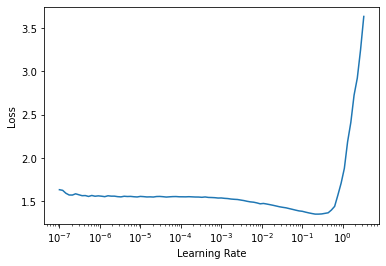

In [36]:
lml.lr_find()

In [37]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p1n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.629735,1.824217,0.390625,6.197938,00:00


{-4.0: (array(['sixty eight', 'sixty five', 'sixty one', 'sixty seven',
         'sixty three'], dtype='<U11'),
  array([  7,   1, 837,   3,   9])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty nine',
         'sixty one', 'sixty seven', 'sixty six', 'sixty thousand',
         'sixty three', 'sixty two'], dtype='<U14'),
  array([115,  66,  55,   1, 344,  75,   4,   1, 135,  61])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty four', 'sixty fourteen', 'sixty nine',
         'sixty nineteen', 'sixty one', 'sixty seven', 'sixty seventy',
         'sixty six', 'sixty thirteen', 'sixty thirty', 'sixty thousand',
         'sixty three', 'sixty two'], dtype='<U14'),
  array([ 22, 102,   1,   2,  85,  75,   1,  23,   1, 168,  96,   3,  40,
           1,   2,  26, 113,  96])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
     

In [38]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p2n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.984942,2.285515,0.375000,9.830749,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty three', 'sixty two'], dtype='<U11'),
  array([ 81,  24,  26, 652,  31,  26,  17])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifty', 'sixty five', 'sixty four',
         'sixty nine', 'sixty one', 'sixty seven', 'sixty seventy',
         'sixty six', 'sixty thousand', 'sixty three', 'sixty twenty',
         'sixty two'], dtype='<U14'),
  array([  6, 149,   1,   1,   1,   2, 111,  88,  11, 217, 111,   1,  11,
          11,  77,   2,  57])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'six

In [39]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p3n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.732881,3.329898,0.281250,27.935482,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven'], dtype='<U11'),
  array([  5,   2,   3, 844,   3])),
 0.0: (array(['sixty eight', 'sixty eighty', 'sixty five', 'sixty four',
         'sixty nineteen', 'sixty one', 'sixty seven', 'sixty six',
         'sixty thirty', 'sixty thousand', 'sixty three', 'sixty two'],
        dtype='<U14'),
  array([108,   2,  76,  81,   1, 413,  73,   1,   1,   3,  51,  47])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         'sixty sixteen', 'sixty sixty', 'sixty ten', 'sixty thirteen',
         'sixty thirty', 'sixty thousand', 'sixty three

In [40]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p4n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.564430,5.702098,0.140625,299.495209,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty one'], dtype='<U9'), array([857])),
 0.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty two'], dtype='<U11'),
  array([ 16,  12,  26, 794,   8,   1])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         'sixty sixteen', 'sixty sixty', 'sixty ten', 'sixty thirteen',
         'sixty thirty', 'sixty thousand', 'sixty three', 'sixty twelve',
         'sixty twenty', 'sixty two', 'sixty xxeos', 'sixty xxfake'],
        dtype='<U15'),
  array([ 25,  96,   7,   8,   8,   6,   4,  78,   8, 105,   4,   1,   3,
           4,   1, 238,  53,   3,   8,  17,   8

In [41]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,8.542905,10.652514,0.041667,42298.781250,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty one'], dtype='<U9'), array([857])),
 0.0: (array(['sixty one'], dtype='<U9'), array([857])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty nineteen', 'sixty one',
         'sixty seven', 'sixty seventy', 'sixty six', 'sixty ten',
         'sixty thirteen', 'sixty thousand', 'sixty three', 'sixty twelve',
         'sixty two', 'sixty xxeos', 'sixty xxfake'], dtype='<U14'),
  array([  3,  69,   1,   5,   3,   2,   4,  44,   3,  77,   1, 539,  39,
           1,  10,   1,   1,   5,  22,   2,  23,   1,   1]))}

In [42]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

In [43]:
lml = dataloader_to_lm_learner(nndl) ; lml.load('nnonlml')

In [44]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n1p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.693148,1.485179,0.471777,4.415754,00:20


{-4.0: (array(['sixty one', 'sixty three'], dtype='<U11'), array([856,   1])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 65,  24,  51, 532,  42,   6, 128,   9])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty sixty', 'sixty ten',
         'sixty thousand', 'sixty three', 'sixty two'], dtype='<U14'),
  array([  3, 108,  88, 101, 209,  93,  64,   1,   1,   7, 120,  62])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         'sixty sixteen', 'sixty sixty', 'sixty ten', 'sixty th

In [45]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n2p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.530133,1.473567,0.473568,4.364776,00:20


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 90,  30,  23, 559,   8,   5, 132,  10])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty four', 'sixty fourteen', 'sixty nine',
         'sixty ninety', 'sixty one', 'sixty seven', 'sixty six',
         'sixty sixty', 'sixty thirteen', 'sixty thousand', 'sixty three',
         'sixty two'], dtype='<U14'),
  array([ 39, 107,   3,   2,  91,  72,   1,   4,   1, 177,  66,  72,   2,
           1,  17, 133,  69])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven

In [46]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n3p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.520468,1.470293,0.469238,4.350509,00:20


{-4.0: (array(['sixty one', 'sixty seven', 'sixty six', 'sixty three'],
        dtype='<U11'),
  array([786,   1,   1,  69])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 21,  80,  29,  37, 370,  36,  35, 211,  38])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty eleven',
         'sixty five', 'sixty forty', 'sixty four', 'sixty nine',
         'sixty nineteen', 'sixty one', 'sixty seven', 'sixty six',
         'sixty sixty', 'sixty thirty', 'sixty thousand', 'sixty three',
         'sixty two'], dtype='<U14'),
  array([ 77,  92,   1,   1,  82,   2,  75,   5,   1, 135,  93,  81,   1,
           1,  19, 116,  75])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         '

In [47]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n4p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.524052,1.470482,0.471680,4.351333,00:21


{-4.0: (array(['sixty', 'sixty four', 'sixty one', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 11,   5, 831,   9,   1])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([127,  50,  25,  91, 302,  36,  45, 124,  57])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four',
         'sixty hundred', 'sixty nine', 'sixty one', 'sixty seven',
         'sixty seventy', 'sixty six', 'sixty thirty', 'sixty thousand',
         'sixty three', 'sixty two'], dtype='<U14'),
  array([107,  79,  70,  90,   1,  11, 128,  77,   2,  78,   1,  23, 111,
          79])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one

In [48]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.527360,1.469217,0.471322,4.345831,00:20


{-4.0: (array(['sixty', 'sixty eight', 'sixty one', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([133,  11, 710,   1,   2])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([212, 102,  22,  31, 297,  32,  18,  80,  63])),
 0.0: (array(['sixty', 'sixty eight', 'sixty fifty', 'sixty five', 'sixty forty',
         'sixty four', 'sixty hundred', 'sixty nine', 'sixty one',
         'sixty seven', 'sixty seventy', 'sixty six', 'sixty thirty',
         'sixty thousand', 'sixty three', 'sixty two'], dtype='<U14'),
  array([120,  97,   1,  72,   1,  64,   2,  13, 134,  65,   1,  77,   1,
          22,  97,  90])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'si

In [49]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

In [50]:
lml = dataloader_to_lm_learner(ondl) ; lml.load('nnonlml')

In [51]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n5p1n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.699759,1.749861,0.385417,5.753801,00:00


{-4.0: (array(['sixty', 'sixty eight', 'sixty one', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([153,   5, 696,   2,   1])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([187,  95,  34,  29, 320,  33,  24,  70,  65])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty five', 'sixty four', 'sixty hundred', 'sixty nine',
         'sixty one', 'sixty seven', 'sixty six', 'sixty sixteen',
         'sixty sixty', 'sixty thirty', 'sixty thousand', 'sixty three',
         'sixty twenty', 'sixty two'], dtype='<U14'),
  array([126,  94,   1,   1,  62,  82,   2,   7, 124,  83,  69,   1,   2,
           1,  13, 101,   1,  87])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty 

In [52]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n5p2n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.070140,2.699489,0.296875,14.872128,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty three', 'sixty two'], dtype='<U11'),
  array([  4,   9,   7,  41, 751,   7,  19,  19])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty four', 'sixty nine', 'sixty one',
         'sixty seven', 'sixty six', 'sixty thousand', 'sixty three',
         'sixty two'], dtype='<U14'),
  array([ 56,  66,   1,   1,  79, 127,   1, 228,  63,  11,   3, 116, 105])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         'sixty sixteen', 'sixty sixty', 'sixty ten', 'sixty thir

In [53]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n5p3n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.120744,5.308406,0.223958,202.028015,00:00


{-4.0: (array(['sixty four', 'sixty one'], dtype='<U10'), array([459, 398])),
 -2.0: (array(['sixty five', 'sixty four', 'sixty one', 'sixty three',
         'sixty two'], dtype='<U11'),
  array([  3, 444, 397,   6,   7])),
 0.0: (array(['sixty eight', 'sixty fifty', 'sixty five', 'sixty four',
         'sixty one', 'sixty seven', 'sixty six', 'sixty three',
         'sixty two'], dtype='<U11'),
  array([ 34,   1,  46, 259, 293,  37,   2,  84, 101])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nineteen', 'sixty one', 'sixty seven', 'sixty seventeen',
         'sixty seventy', 'sixty six', 'sixty sixteen', 'sixty sixty',
         'sixty ten', 'sixty thirteen', 'sixty thirty', 'sixty thousand',
         'sixty three', 'sixty twelve', 'sixty twenty', 'sixty two',
         'sixty xxeos', 'sixty xxfake', 

In [54]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n5p4n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.008741,7.661919,0.156250,2125.833252,00:00


{-4.0: (array(['sixty four', 'sixty one'], dtype='<U10'), array([ 17, 840])),
 -2.0: (array(['sixty four', 'sixty one'], dtype='<U10'), array([250, 607])),
 0.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty three', 'sixty two'], dtype='<U11'),
  array([  4,   9, 342, 427,   1,  17,  57])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty fifteen', 'sixty fifty', 'sixty five', 'sixty forty',
         'sixty four', 'sixty fourteen', 'sixty hundred', 'sixty nineteen',
         'sixty one', 'sixty seven', 'sixty seventeen', 'sixty seventy',
         'sixty six', 'sixty sixteen', 'sixty sixty', 'sixty ten',
         'sixty thirteen', 'sixty thirty', 'sixty thousand', 'sixty three',
         'sixty twelve', 'sixty twenty', 'sixty two', 'sixty xxfld'],
        dtype='<U15'),
  array([ 20,  55,   4,   3,   1,   4,  69,   2, 183,   2,   1,   3, 202,
          64,   1,   6,  18,   1,   2,   3,   2,   1,   1,

In [55]:
lml.fit_one_cycle(1, -1e-2) ; lml.save('nnon-10p5n5p5n'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,10.850733,10.880170,0.135417,53112.621094,00:00


{-4.0: (array(['sixty one'], dtype='<U9'), array([857])),
 -2.0: (array(['sixty one'], dtype='<U9'), array([857])),
 0.0: (array(['sixty four', 'sixty one', 'sixty two'], dtype='<U10'),
  array([ 77, 778,   2])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty five', 'sixty four',
         'sixty one', 'sixty seven', 'sixty six', 'sixty sixteen',
         'sixty sixty', 'sixty ten', 'sixty thirteen', 'sixty thousand',
         'sixty three', 'sixty two'], dtype='<U14'),
  array([  8,  21,   3,  38, 221, 397,  32,   5,   1,   2,   1,   1,   1,
          52,  74]))}

In [56]:
lml.save('nnonlml')

Path('models/nnonlml.pth')

In [57]:
lml = dataloader_to_lm_learner(nndl) ; lml.load('nnonlml')

In [58]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n1p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.710440,1.481892,0.467025,4.401266,00:20


{-4.0: (array(['sixty one', 'sixty three'], dtype='<U11'), array([853,   4])),
 -2.0: (array(['sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([  3,  13,  29, 613,   4,   2, 173,  20])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 14,  72,  79, 108, 224,  51,  58, 166,  85])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty nine',
         'sixty nineteen', 'sixty ninety', 'sixty one', 'sixty seven',
         'sixty seventeen', 'sixty seventy', 'sixty six', 'sixty sixteen',
         'sixty sixty', 'sixty ten', 'sixty thirteen', 'sixty thirty',
         'sixty thousand', 'sixty three', 'sixty twelv

In [59]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n2p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.527426,1.474667,0.468587,4.369581,00:20


{-4.0: (array(['sixty one', 'sixty three'], dtype='<U11'), array([856,   1])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 30,   4,   8,  11, 606,  10,  14, 138,  36])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([ 74,  63,  65,  85, 201,  76,  65, 139,  89])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         'sixty sixteen', 'sixty sixty', 'sixty ten', 'sixty thirteen',
         'sixty thirty', 'sixty thousan

In [60]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n3p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.521377,1.473431,0.462207,4.364183,00:20


{-4.0: (array(['sixty'], dtype='<U5'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([685,  10,   3,   5, 109,   2,   3,  28,  12])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty nine',
         'sixty ninety', 'sixty one', 'sixty seven', 'sixty seventy',
         'sixty six', 'sixty sixteen', 'sixty thousand', 'sixty three',
         'sixty twenty', 'sixty two'], dtype='<U14'),
  array([214,  73,  46,  87,   1,   1, 156,  41,   1,  52,   1,   2, 115,
           1,  66])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 's

In [61]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n4p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.520733,1.473021,0.463184,4.362392,00:20


{-4.0: (array(['sixty'], dtype='<U5'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty four', 'sixty one', 'sixty seven',
         'sixty six', 'sixty three', 'sixty two'], dtype='<U11'),
  array([833,   1,   4,   9,   1,   2,   4,   3])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty five', 'sixty four',
         'sixty hundred', 'sixty nine', 'sixty nineteen', 'sixty ninety',
         'sixty one', 'sixty seven', 'sixty six', 'sixty sixty',
         'sixty thirty', 'sixty thousand', 'sixty three', 'sixty two'],
        dtype='<U14'),
  array([269,  64,   3,  66,  75,   5,   2,   1,   1,  84,  73,  59,   1,
           1,   3,  66,  84])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventee

In [62]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n5p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.513685,1.470454,0.469954,4.351209,00:28


{-4.0: (array(['sixty'], dtype='<U5'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([772,  12,   5,  13,  19,   7,   2,  11,  16])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty four', 'sixty hundred', 'sixty nine',
         'sixty one', 'sixty seven', 'sixty seventy', 'sixty six',
         'sixty sixty', 'sixty ten', 'sixty thousand', 'sixty three',
         'sixty two'], dtype='<U14'),
  array([216,  88,   1,   1,  70,  89,   1,   1,  95,  59,   1,  47,   1,
           1,   5,  82,  99])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty 

In [63]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n6p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.506677,1.468627,0.474447,4.343267,00:24


{-4.0: (array(['sixty'], dtype='<U5'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([578,  29,  22,  22,  94,  19,   6,  56,  31])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty fifty',
         'sixty five', 'sixty forty', 'sixty four', 'sixty hundred',
         'sixty nine', 'sixty ninety', 'sixty one', 'sixty seven',
         'sixty seventeen', 'sixty six', 'sixty thirty', 'sixty thousand',
         'sixty three', 'sixty twelve', 'sixty twenty', 'sixty two'],
        dtype='<U15'),
  array([168,  93,   2,   1,  72,   2,  78,   2,   6,   1, 112,  90,   1,
          55,   1,   5,  93,   1,   1,  73])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         '

In [64]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n7p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.517172,1.468764,0.470638,4.343861,00:20


{-4.0: (array(['sixty'], dtype='<U5'), array([857])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([637,  14,   9,  26, 103,   9,   5,  23,  31])),
 0.0: (array(['sixty', 'sixty eight', 'sixty fifty', 'sixty five', 'sixty four',
         'sixty fourteen', 'sixty hundred', 'sixty nine', 'sixty one',
         'sixty seven', 'sixty six', 'sixty thousand', 'sixty three',
         'sixty two'], dtype='<U14'),
  array([187,  83,   1,  71,  97,   1,   2,   7, 108,  61,  79,   4,  70,
          86])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', 'sixty six',
         '

In [65]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n8p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.509688,1.466905,0.467448,4.335796,00:22


{-4.0: (array(['sixty', 'sixty one'], dtype='<U9'), array([856,   1])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([528,  36,  18,  29, 126,  19,  25,  29,  47])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighty', 'sixty five', 'sixty four',
         'sixty hundred', 'sixty nine', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventy', 'sixty six', 'sixty thirty',
         'sixty thousand', 'sixty three', 'sixty twenty', 'sixty two'],
        dtype='<U14'),
  array([192,  90,   1,  59,  65,   1,   5,   3, 115,  67,   1,  79,   1,
           3,  80,   2,  93])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty 

In [66]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n9p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.505049,1.468488,0.464974,4.342663,00:21


{-4.0: (array(['sixty', 'sixty eight', 'sixty four', 'sixty one', 'sixty six',
         'sixty three', 'sixty two'], dtype='<U11'),
  array([431,   6,   2, 369,   5,  21,  23])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([213,  61,  26,  59, 200,  43,  89,  92,  74])),
 0.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty nine',
         'sixty nineteen', 'sixty one', 'sixty seven', 'sixty seventy',
         'sixty six', 'sixty thousand', 'sixty three', 'sixty two'],
        dtype='<U14'),
  array([113,  76,  74,  85,   9,   1, 104,  94,   2, 102,   6, 103,  88])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', '

In [67]:
lml.fit_one_cycle(1, 1e-2) ; lml.save('nnon-10p5n5p5n10p'); sixteenth_to_two_temperatures_after_sixty(lml)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.509657,1.470120,0.464486,4.349757,00:20


{-4.0: (array(['sixty', 'sixty three'], dtype='<U11'), array([856,   1])),
 -2.0: (array(['sixty', 'sixty eight', 'sixty five', 'sixty four', 'sixty one',
         'sixty seven', 'sixty six', 'sixty three', 'sixty two'],
        dtype='<U11'),
  array([433,  24,  22,  47,  87,  29,  39,  87,  89])),
 0.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty five',
         'sixty four', 'sixty hundred', 'sixty nine', 'sixty one',
         'sixty seven', 'sixty six', 'sixty thousand', 'sixty three',
         'sixty twelve', 'sixty two'], dtype='<U14'),
  array([175,  65,   1,  69,  66,   1,  13, 106,  85,  76,   5, 110,   1,
          84])),
 2.0: (array(['sixty', 'sixty eight', 'sixty eighteen', 'sixty eighty',
         'sixty eleven', 'sixty fifteen', 'sixty fifty', 'sixty five',
         'sixty forty', 'sixty four', 'sixty fourteen', 'sixty hundred',
         'sixty nine', 'sixty nineteen', 'sixty ninety', 'sixty one',
         'sixty seven', 'sixty seventeen', 'sixty seventy', '

In [68]:
lml.save('nnonlml')

Path('models/nnonlml.pth')